### 1. Сформировать с помощью sklearn.make_classification датасет из 100 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote).


In [116]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification
from sklearn import model_selection

import numpy as np

In [142]:
# сгенерируем данные, представляющие собой 100 объектов с 5-ю признаками
classification_data, classification_labels = make_classification(n_samples=100,
                                                                 n_features=2, n_informative=2, 
                                                                 n_classes=2, n_redundant=0, 
                                                                 n_clusters_per_class=1, random_state=23)

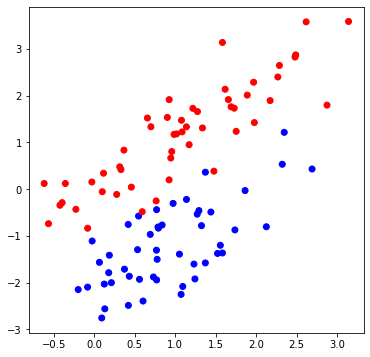

In [118]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(6,6))
plt.scatter(classification_data[:, 0], classification_data[:, 1], 
              c=classification_labels, cmap=colors);

Реализуем генерацию $N$ бутстрап-выборок и подмножества признаков для нахождения разбиения в узле.

In [119]:
def get_bootstrap(data, labels, N):
    
    n_samples = data.shape[0]
    bootstrap = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_lables = np.zeros(labels.shape)
#         mask= ...
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples - 1)
            b_data[j] = data[sample_index]
            b_lables[j] = labels[sample_index]
#             mask[j]
        bootstrap.append((b_data, b_lables))

    return bootstrap

In [120]:
def get_subsample(len_sample):

    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
        
    return subsample

In [121]:
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [122]:
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):

        classes = {} 
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
   
        prediction = max(classes, key=classes.get)
        return prediction

In [123]:
def gini(labels):

    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1

    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [124]:
def gain(left_labels, right_labels, root_gini):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return root_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [125]:
def split(data, labels, column_index, t):
    
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
        
    true_data = data[left]
    false_data = data[right]
    
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [126]:
def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf_samples = 5

    root_gini = gini(labels)

    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    feature_subsample_indices = get_subsample(n_features) # выбираем случайные признаки
    
    for index in feature_subsample_indices:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
#             if len(true_data) < min_leaf_samples or len(false_data) < min_leaf_samples:
#                 continue
            
            current_gain = gain(true_labels, false_labels, root_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [127]:
def build_tree(data, labels):

    gain, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if gain == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

Теперь добавим функцию формирования случайного леса.

In [128]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

In [129]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [130]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

голосование деревьев

In [131]:
def tree_vote(forest, data):
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    predictions_per_object = list(zip(*predictions))
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
    
    return voted_predictions

In [149]:
# Разобьем выборку на обучающую и тестовую

from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(classification_data, 
                                                                    classification_labels, 
                                                                    test_size=0.3,
                                                                    random_state=23)

In [150]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [151]:
for tree_numbers in (1, 3, 10, 50):
    
    my_forest = random_forest(train_data, train_labels, tree_numbers)
    train_answers = tree_vote(my_forest, train_data)
    test_answers = tree_vote(my_forest, test_data)
    train_accuracy = accuracy_metric(train_labels, train_answers)
    test_accuracy = accuracy_metric(test_labels, test_answers)
    
    print(f'Train: {train_accuracy:.2f}, Test: {test_accuracy:.2f}')

Train: 92.86, Test: 90.00
Train: 98.57, Test: 93.33
Train: 100.00, Test: 93.33
Train: 100.00, Test: 90.00


In [152]:
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

<ipython-input-153-7d9f94034da4>:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
<ipython-input-153-7d9f94034da4>:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)


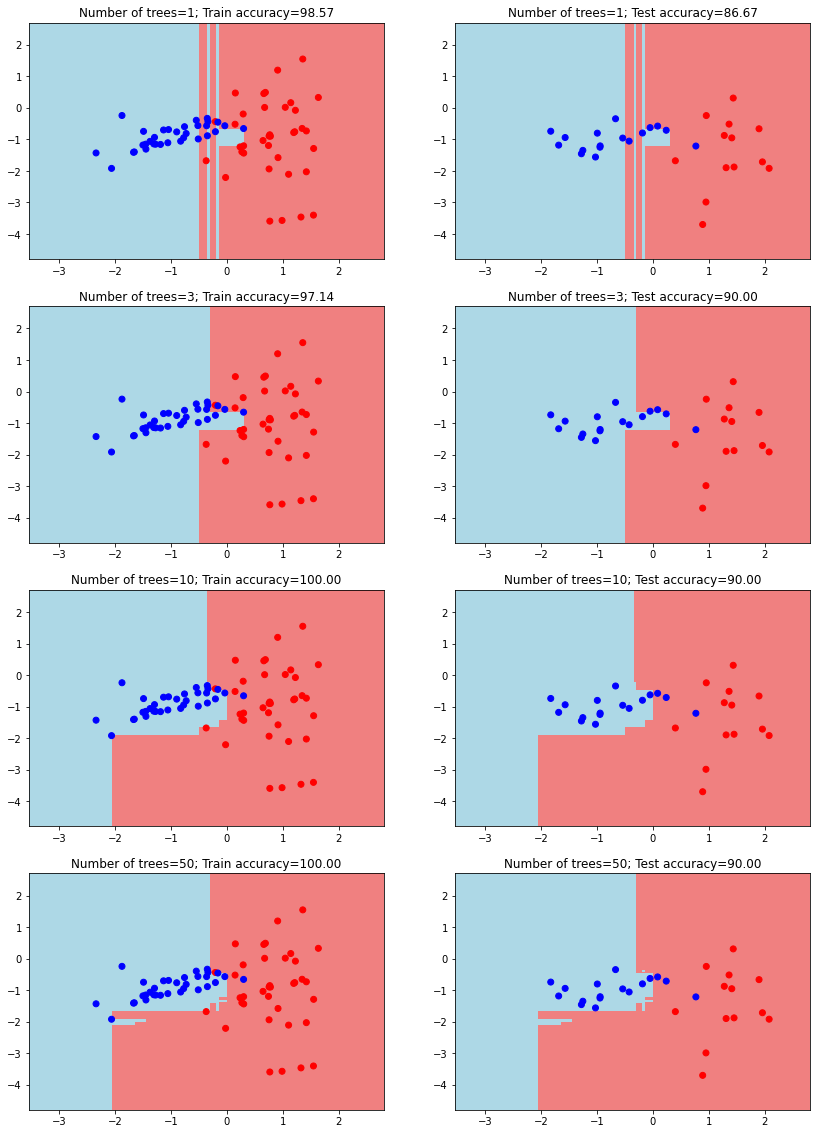

In [153]:
xx, yy = get_meshgrid(train_data)
plt.figure(figsize = (14, 20))
trees = (1, 3, 10, 50)

for tree in range(len(trees)):
    my_forest = random_forest(train_data, train_labels, trees[tree])
    train_answers = tree_vote(my_forest, train_data)
    answers = tree_vote(my_forest, test_data)
    train_accuracy = accuracy_metric(train_labels, train_answers)
    test_accuracy = accuracy_metric(test_labels, answers)
    mesh_predictions = np.array(tree_vote(my_forest, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)

    plt.subplot(4, 2, 2 * (tree + 1) - 1)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Number of trees={trees[tree]}; Train accuracy={train_accuracy:.2f}')

    plt.subplot(4, 2, 2 * (tree + 1))
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Number of trees={trees[tree]}; Test accuracy={test_accuracy:.2f}')

### 2. Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.


С увеличением количества деревьев модель пытается подстроиться под модель и усложнить гиперплоскость (хотя на графике не отображаются деревья, замтно усложнение рисунка). Данных не много, но не похоже, чтобы можель переобучилась, т.к. лучайные леса страхуют от переобучения (из методички: "по точности на тестовой выборке можно сказать, что при увеличении количества деревьев до 50 наш лес не переобучается. Это одна из основных особенностей случайного леса - он редко переобучается при увеличении числа базовых алгоритмов, а ошибка выходит на асимптоту")

3. *Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.

In [155]:
def out_of_bag(classification_data, classification_labels, sample_length):
    data_len = len(classification_data)
    index = np.random.randint(0, data_len, sample_length)
    set_indx = set(index) # оставляем только уникальные индексы
    rev_index = []  # пустой список невыбранных индексов
    # проходимся по списку и создаём список тех индексов, элементы которых не выбрали
    for i in range(data_len):
        if i not in set_indx:
            rev_index.append(i)
            
    train_data = classification_data[index]
    test_data = classification_data[rev_index]
    train_labels = classification_labels[index]
    test_labels = classification_labels[rev_index]
    return train_data, test_data, train_labels, test_labels

лес из 3 деревьев

In [157]:
%%time
n_trees = 3
my_forest_3 = random_forest(train_data, train_labels, n_trees)

Wall time: 307 ms


In [158]:
train_answers = tree_vote(my_forest_3, train_data)

In [159]:
test_answers = tree_vote(my_forest_3, test_data)

In [160]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 3 деревьев на обучающей выборке: 100.000
Точность случайного леса из 3 деревьев на тестовой выборке: 90.000


In [162]:
for tree_numbers in (1, 3, 10, 50):
    
    my_forest = random_forest(train_data, train_labels, tree_numbers)
    train_answers = tree_vote(my_forest, train_data)
    test_answers = tree_vote(my_forest, test_data)
    train_accuracy = accuracy_metric(train_labels, train_answers)
    test_accuracy = accuracy_metric(test_labels, test_answers)
    
    print(f'Train: {train_accuracy:.3f}, Test: {test_accuracy:.3f}')

Train: 95.714, Test: 93.333
Train: 97.143, Test: 86.667
Train: 98.571, Test: 86.667
Train: 100.000, Test: 90.000


In [163]:
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

<ipython-input-164-913f7d821a82>:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
<ipython-input-164-913f7d821a82>:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)


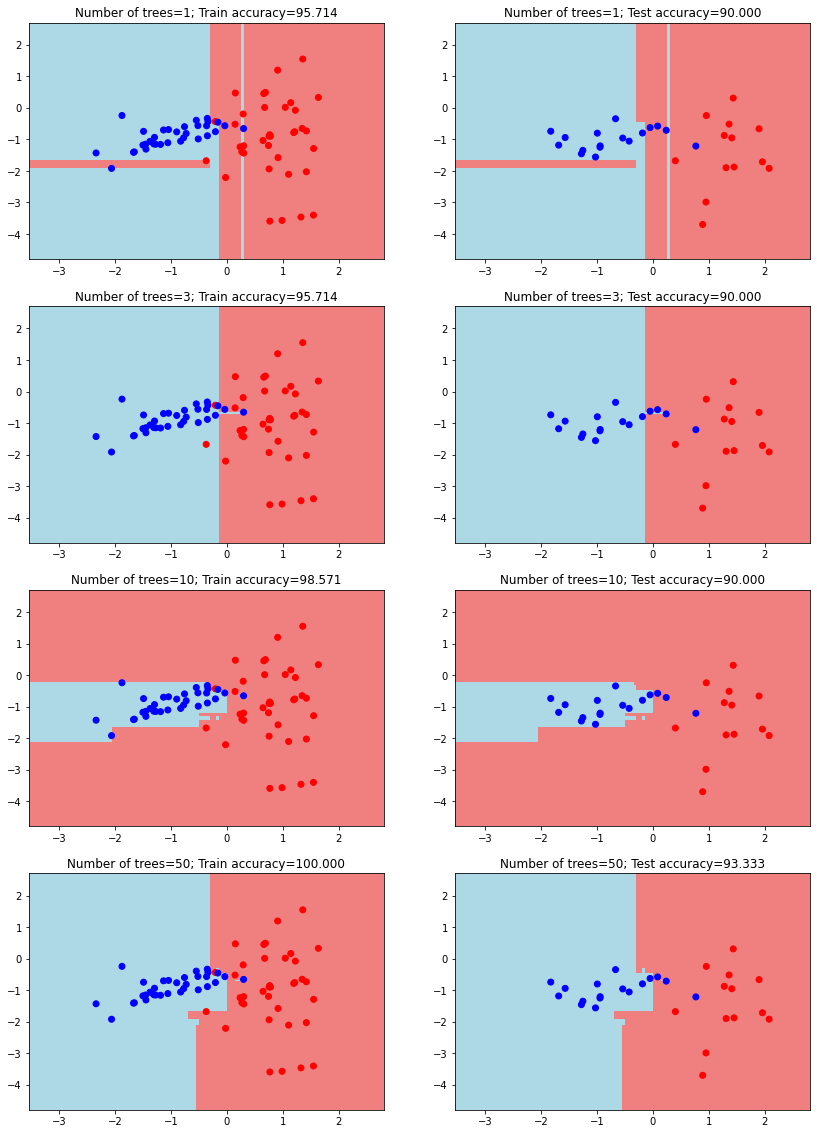

In [164]:
xx, yy = get_meshgrid(train_data)
plt.figure(figsize = (14, 20))
trees = (1, 3, 10, 50)

for tree in range(len(trees)):
    my_forest = random_forest(train_data, train_labels, trees[tree])
    train_answers = tree_vote(my_forest, train_data)
    answers = tree_vote(my_forest, test_data)
    train_accuracy = accuracy_metric(train_labels, train_answers)
    test_accuracy = accuracy_metric(test_labels, answers)
    mesh_predictions = np.array(tree_vote(my_forest, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)

    plt.subplot(4, 2, 2 * (tree + 1) - 1)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Number of trees={trees[tree]}; Train accuracy={train_accuracy:.3f}')

    plt.subplot(4, 2, 2 * (tree + 1))
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Number of trees={trees[tree]}; Test accuracy={test_accuracy:.3f}')